# PD2

In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps

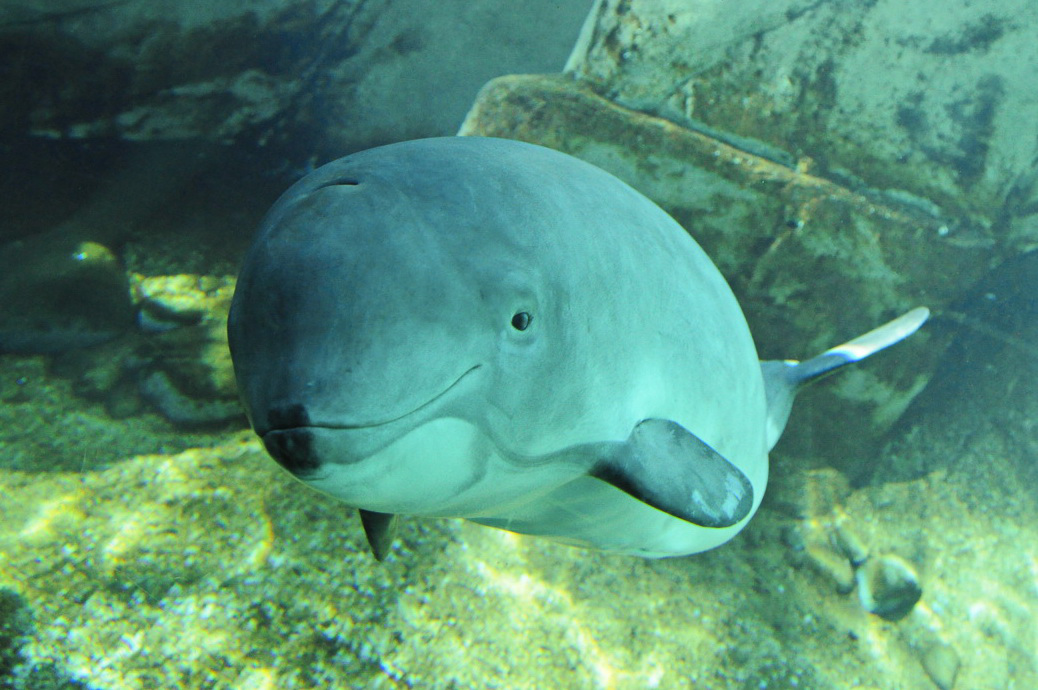

In [2]:
image = Image.open('mor.jpg')
image

## Co zrobimy?

Nie za bardzo mogłem znaleźć przykład fajnego zdjęcia z podanym filtrem. Znalazłem za to filtr, który ma na celu uwydatnianie krawędzi. Myślę, że będzie to dość oczywiste czy wyjdzie czy nie wyjdzie :)

### Nakładanie filtra konwolucyjnego

In [56]:
def convolutionSimple(imgArray: np.array, imgFilter: np.array, padding: int = 1, stride: int = 1):
    def _convolve2D(imgArray, imgFilter, padding, stride):
        (x, y) = imgArray.shape
        padded = np.insert(imgArray, y, np.zeros(shape=(padding, x)), axis = 1)
        padded = np.insert(padded, 0, np.zeros(shape=(padding, x)), axis = 1)
        padded = np.insert(padded, x, np.zeros(shape=(padding, y+2*padding)), axis = 0)
        padded = np.insert(padded, 0, np.zeros(shape=(padding, y+2*padding)), axis = 0)
        (x, y) = padded.shape
        (xf, yf) = imgFilter.shape

        output = np.zeros(shape=((x-xf)//stride + 1, (y-yf)//stride + 1) )
        (m, n) = output.shape

        for i in range(m):
            for j in range(n):
                output[i, j] = (padded[i*stride:(i*stride+xf), j*stride:(j*stride+yf)] * imgFilter).sum()
                if output[i, j] > 255:
                    output[i, j] = 255
                elif output[i, j] < 0:
                    output[i, j] = 0
        return output
    
    if len(imgArray.shape) == 2:
        return _convolve2D(imgArray, imgFilter, padding, stride)       
    else:
        color1 = imgArray[:,:,0]
        color2 = imgArray[:,:,1]
        color3 = imgArray[:,:,2]
        color1 = _convolve2D(color1, imgFilter[0], padding, stride)
        color2 = _convolve2D(color2, imgFilter[1], padding, stride)
        color3 = _convolve2D(color3, imgFilter[2], padding, stride)
        return np.dstack((color1, color2, color3))

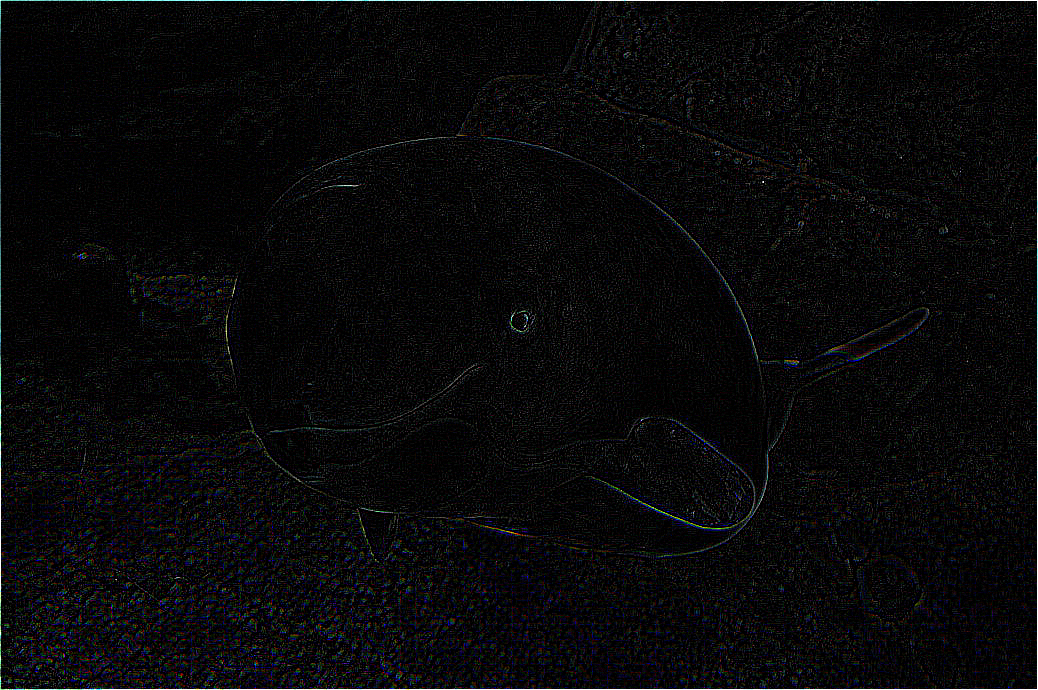

In [57]:
imgArray = np.asarray(image)
imgFilter = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1],
])
imgFilter = [imgFilter, imgFilter, imgFilter]
convolved = convolutionSimple(imgArray, imgFilter, 1, 1)
Image.fromarray(convolved.astype(np.uint8))

Zdecydowanie lepiej będzie to wyglądać na czarno białym.

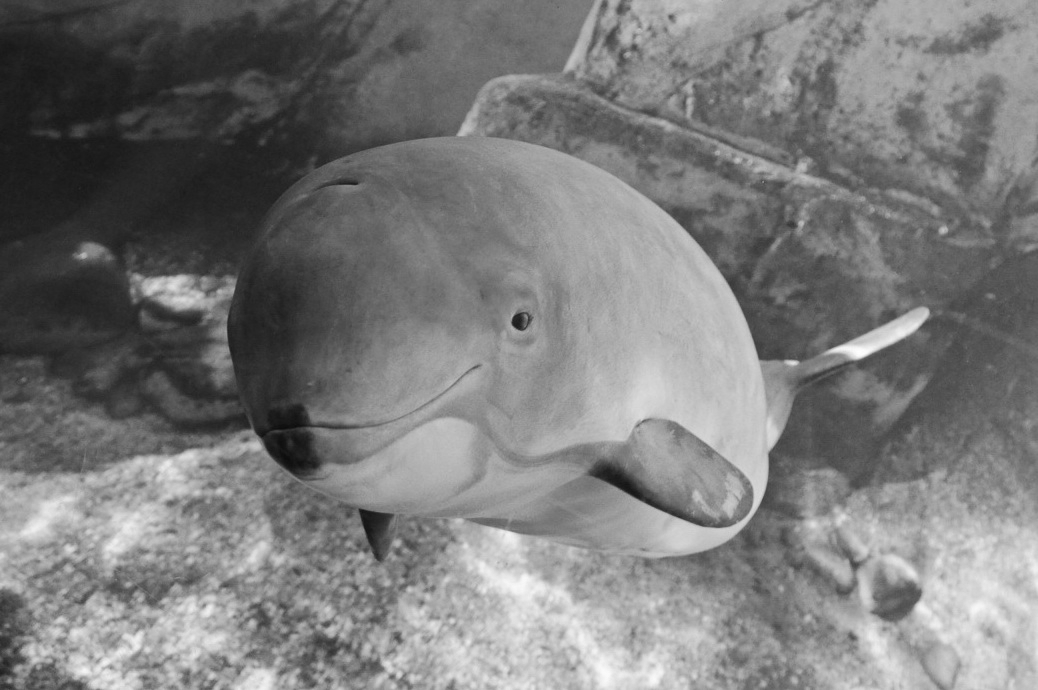

In [58]:
imageG = ImageOps.grayscale(image)
imageG

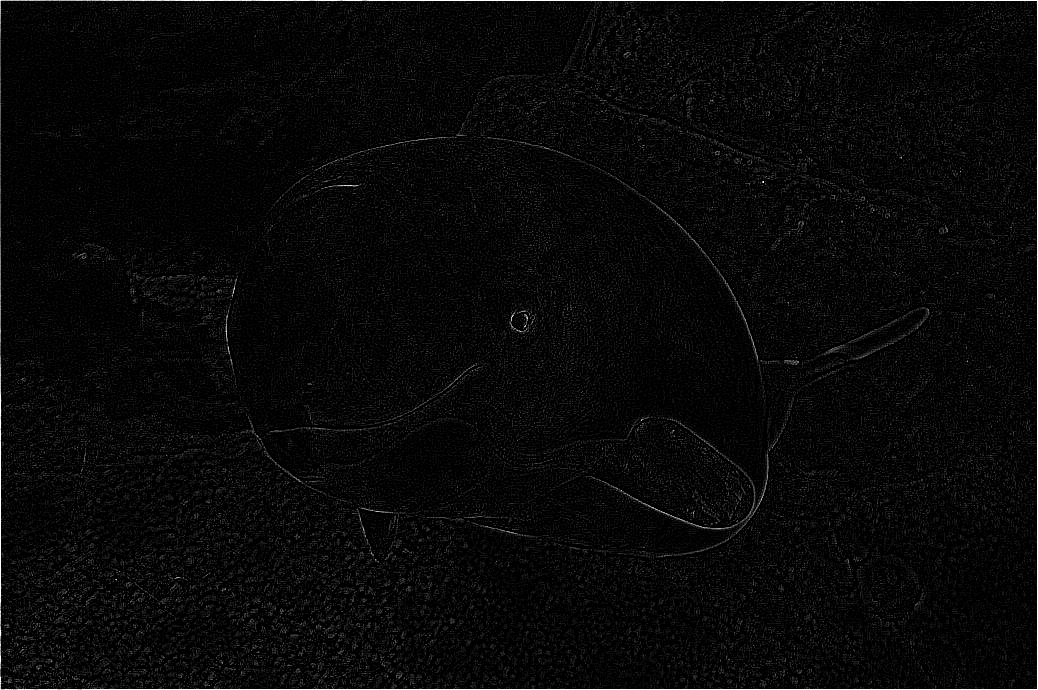

In [59]:
imgArrayG = np.asarray(imageG)
imgFilter = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1],
])
convolved = convolutionSimple(imgArrayG, imgFilter, 1, 1)
Image.fromarray(convolved.astype(np.uint8))

## metoda druga - mnożenie macierzy (niekoniecznie jak poprzednio elementwise)

To niestety tylko mój nieudany draft. Zawiodło moje planowanie czasu i nie zdążyłem :(

In [96]:
def convolutionFast(imgArray: np.array, imgFilter: np.array, padding: int = 1, stride: int = 1):
    def _im2col(imgArray, imgFilter, stride):
        in_c, in_h, in_w = imgArray.shape
        f_h, f_w = imgFilter.shape
        out_h = (in_h - f_h)//stride + 1
        out_w = (in_w - f_w)//stride + 1
        
        col = np.zeros([out_h*out_w, in_c*f_h*f_w])
        
        for i in range(out_h):
            for j in range(out_w):
                patch = img[..., i*stride:i*stride+f_h, j*stride:j*stride+f_w]
                col[i*out_w+j,:] = np.reshape(patch,-1)
        return col
    
    
    img_0 = np.pad(imgArray[:, :, 0], [(1, 1), (padding, padding)], 'constant')
    img_1 = np.pad(imgArray[:, :, 1], [(1, 1), (padding, padding)], 'constant')
    img_2 = np.pad(imgArray[:, :, 2], [(1, 1), (padding, padding)], 'constant')
    img = np.array([img_0, img_1, img_2])
    
    in_c, in_h, in_w = imgArray.shape
    f_h, f_w = imgFilter.shape
    out_h = (in_h - f_h)//stride + 1
    out_w = (in_w - f_w)//stride + 1
    
    im_col = _im2col(img, f_h, f_w, stride)
    filter_col = np.reshape()
    mul = im_col.dot()
    
    
    
    return _im2col(img, imgFilter, stride)

In [97]:
A = convolutionFast(imgArray, imgFilter)

In [100]:
A

array([[  0.,   0.,   0., ...,   0.,  63.,  64.],
       [  0.,   0.,   0., ...,  63.,  64.,  65.],
       [  0.,   0.,   0., ...,  64.,  65.,  67.],
       ...,
       [150., 151., 154., ...,   0.,   0.,   0.],
       [151., 154., 156., ...,   0.,   0.,   0.],
       [154., 156.,   0., ...,   0.,   0.,   0.]])

In [102]:
imgFilter.reshape(-1 ,1)

array([[-1],
       [-1],
       [-1],
       [-1],
       [ 8],
       [-1],
       [-1],
       [-1],
       [-1]])